In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
import gym
import matplotlib.pyplot as plt
import sys

sys.path.append('..')

from gym_minigrid_navigation.utils import show_video

plt.style.use('ggplot')

%load_ext autoreload
%autoreload 2

### environment 

In [3]:
from gym_minigrid_navigation.environments import gen_wrapped_env

env_config = {
    'env_type': 'gym_minigrid',
    'env_task': 'MiniGrid-Dynamic-Obstacles',
    'grid_size': 16,
    'rgb_image': True,
    'tile_size': 8,
}

env = gen_wrapped_env(env_config)

### model 

In [4]:
from models import StateDistanceNetwork
from gym_minigrid_navigation.encoders import SimpleCNN

grid_size = env_config['grid_size'] * env_config.get('tile_size', 1)
encoder_config = {
    'n_channels': [32, 64, 64],
    'kernel_sizes': [8, 4, 3],
    'strides': [4, 2, 1],
    'hidden_layers_sizes': [32]
}

encoder = SimpleCNN(grid_size, encoder_config)

net = StateDistanceNetwork(encoder=encoder, action_size = env.action_space.n, config={'hidden_size': 128})
net

StateDistanceNetwork(
  (encoder): SimpleCNN(
    (conv_net): Sequential(
      (0): Permute()
      (1): Conv2d(3, 32, kernel_size=(8, 8), stride=(4, 4))
      (2): ReLU(inplace=True)
      (3): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
      (4): ReLU(inplace=True)
      (5): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
      (6): ReLU(inplace=True)
    )
    (fc): Sequential(
      (0): Linear(in_features=9216, out_features=32, bias=True)
      (1): ReLU()
    )
  )
  (fc): Sequential(
    (0): Linear(in_features=64, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=3, bias=True)
    (3): LogSoftmax(dim=-1)
  )
)

### training

In [5]:
import torch
from torch import nn
import numpy as np

from train_state_distance_network import rollout

optimizer = torch.optim.Adam(net.parameters(), lr=1e-4, weight_decay=1e-6)
nll_loss = nn.NLLLoss()

for roll in range(1000):
    
    states, next_states, actions = rollout(env)
    
    for epoch in range(5):
        optimizer.zero_grad()
        predicted_actions = net.forward(states, next_states)
        loss = nll_loss(predicted_actions, actions)
        loss.backward()
        optimizer.step()
    if roll%100==0:
        print("Rollout: {0}, loss: {1}".format(roll, loss.item()))

Rollout: 0, loss: 0.5700077414512634
Rollout: 100, loss: 0.9336525201797485
Rollout: 200, loss: 0.8000394701957703
Rollout: 300, loss: 0.09025447815656662
Rollout: 400, loss: 0.02077731303870678
Rollout: 500, loss: 0.009412623941898346
Rollout: 600, loss: 0.0002696018782444298
Rollout: 700, loss: 0.00036106296465732157
Rollout: 800, loss: 2.1529429432121105e-05
Rollout: 900, loss: 7.827551598893479e-05


### visualisation 

In [6]:
env.reset()
grid_size = env.unwrapped.grid.encode().shape[0]
env.unwrapped.agent_pos = np.random.randint(1, grid_size - 2, 2)

state1, _, _, _ = env.step(2)
state2, _, _, _ = env.step(0)
state3, _, _, _ = env.step(1)

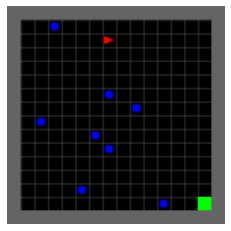

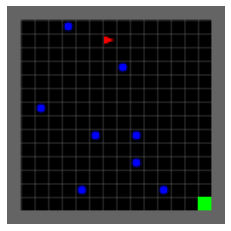

Same position agent distance: 3.092606544494629 (should be small)
Different position agent distance: 186.82891845703125 (should be big)


In [7]:
device = 'cpu'

plt.axis(False)
plt.imshow(state1['image'])
plt.show()
plt.axis(False)
plt.imshow(state3['image'])
plt.show()

embeds = net.encoder(torch.from_numpy(np.array([state1['image'], state2['image'], state3['image']])).to(device, dtype=torch.float32))

d_same = torch.dist(embeds[0], embeds[2], 2).detach().item()
d_diff = torch.dist(embeds[0], embeds[1], 2).detach().item()

print(f"Same position agent distance: {d_same} (should be small)")
print(f"Different position agent distance: {d_diff} (should be big)")